In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

# Inferring a Binomial Probability via Exact Analysis (Chapter 6)

* Goal: We have a series of Boolean experiments (independent coin tosses). We want to analyze how the prior belief about bias should be updated after observing this series.

* Method: Pen and pencil analysis

* We have two nominal outcomes $y\in \{0,1\}$. 
* Nominal means that they are unordered.  The numeric values 0 and 1 have no meaning, we could flip them. We chose them just for convenience.

## Likelihood

* We start with seeking the likelihood function.  Recall that for a given coin the outcome $y$ is described by a Bernoulli distribution with parameter $\theta$:

$$
p (y \mid \theta) = \theta^y (1-\theta)^{(1-y)}
$$

* Note that $p (y=1 \mid \theta) = \theta^1\theta^0 = \theta$; just a reminder that $\theta$ is basically the probability of success.

* The above function is a **probability distribution** given a concrete $\theta$ value.

* However, when we do an observation of (learning from) an experiment result we know the value of $y$, not the value of $\theta$.

* The reinterpretation of a probability function in which the outcome is known, but the parameters are free is called **likelihood**.

* Note that likelihood **is not a probability**, as it does not satisfy Kolmogorov's axioms.  In particular, for $y=1$,

$$
\int_o^1 \theta^y(1-\theta)^{(1-y)} d\theta = \int_0^1 \theta d\theta = \frac{1}{2}
$$

* Recall, that likelihood is not a function that gives a probability of an outcome, but a function that tells us (on the scale from 0 to 1) how well a given valuation of model parameters explain the outcome.

* Last week we agreed that if we know a result of $N$ experiments then the likelihood is

$$
p (\{y_i\}_{i=1}^N \mid \theta) = \theta^{\#\textrm{heads}} (1-\theta)^{\#\textrm{tails}}
$$

* This chapter changes the notation slightly. We assume $N$ experiments and $z$ successes, so $\#\textrm{heads}=z$ and $\#\textrm{tails}=N-z$. 

* Then

$$
p (\{y_i\}_{i=1}^{N} \mid \theta) = \theta^{z} (1-\theta)^{N-z}
$$

* Recall that Bayes theorem says (specialized for the experiment of $N$ coin tosses as above):

$$
p (\theta \mid \{y_i\}_{i=1}^{N}) = \frac{p (\{y_i\}_{i=1}^{N} \mid \theta) \cdot p(\theta)}{p(\{y_i\}_{i=1}^{N})}
$$

* So the above definition of likelihood is something we will need to plug in the ayes rule above in order to compute the posterior probability distribution over $\theta$, which captures what we have learnt about $\theta$ after executing the experiment.

## Prior

* What should be the prior? It would be nice to have a prior function $p(\theta)$ such that when multipled by the likelihood. $p(y \mid \theta)p(\theta)$ we get a function of the same form. 
* This way after learning from $N$ experiments, we obtain a posterior that looks the same as the prior, so if we run more experiments, we can use the same analytical procedure to continue learning / inference.
* A prior which, when multiplied by the likelihood, gives a function of the same form is called a **conjugate prior** wrt this likelihood function.
* Since we are working analytically, we also need to be able to compute the denominator in the Bayes theorem, $p(\{y_i\}_{i=1}^{N}) = \int_0^1 p (\{ y_i\} \mid \theta) p (\theta)d\theta$, analytically. Computing integrals is not always easy or possible, so we need a form that would allow solving this. 
* Our likelihood is of the form $\theta^a(1-\theta)^b$, so if we multiply it by some function of the same form $\theta^k(1-\theta)^l$ we will still obtain a thing of the same format: $\theta^{a+k}(1-\theta)^{b+l}$.
* A probability density function (Q. why do we need a density for the prior here?) is called Beta:
$$
p(\theta \mid a,b) = \textrm{beta} (\theta | a,b) = \frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)} = \frac{\theta^{a-1}(1-\theta)^{b-1}}{ \int_0^1 \theta^{a-1}(1-\theta)^{b-1}d\theta }
$$
* where the denominator is the normalizing function also called the beta function $\textrm{B}(a,b)$ (the entire distribution is called a beta distribution, and the denominator is called the beta function)
* The beta distribution is only defined for $\theta\in[0,1]$ and for postiive values of $a$ and $b$ (which suits our case well)
* Below we explore the Beta distribution in practice, to give you an idea how to pick the parameter for your prior.

* In PyMC3 Beta distribution is in [pymc3.distributions.continuous.Beta](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta)
* Below we reconstruct Fig. 6.1 by instantiating the above beta function and using it for plotting.
* In PyMC3, any distribution has a function logp that returns logarithm of probability values of random variables at given point.  
* We instantiate the beta distribution for all combinations of parameters $\alpha$ and $\beta$, like in the book, compute logp values in 100 points, take natural exponential of these values, and plot.
* Beware, the computation may take a bit of time (feels like a minute or so)

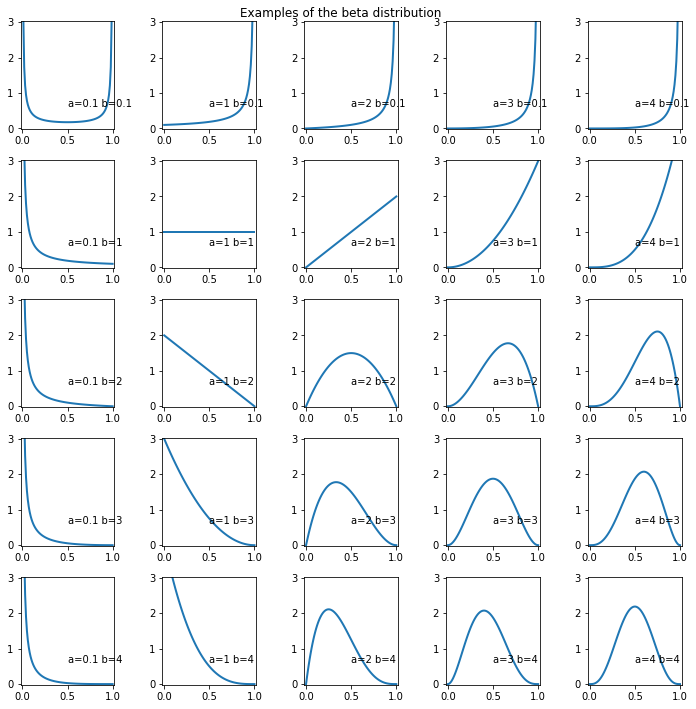

In [2]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
fig.suptitle('Examples of the beta distribution')
fig.tight_layout()
fig.subplots_adjust(top=0.96)

params = [0.1, 1, 2, 3, 4]
domain = np.linspace(0.0, 1.0, 100)
for i in range(0, 5):
    for j in range(0, 5):
        with pm.Model():
            beta = pm.Beta(
                name=f"theta", 
                alpha=params[j], 
                beta=params[i], 
                transform=None
            )
            image = [ math.exp( beta.logp( {"theta": theta} ) ) # scipy also implements density functions, might be easier and faster to use directly
                         for theta in domain
                    ]
            ax[i][j].plot(domain, image, linewidth=2)
            ax[i][j].text(0.5, 0.6, f"a={params[j]} b={params[i]}")
            ax[i][j].axis([-0.02, 1.02, -0.02, 3.02])
plt.show()

* The first aprameter, $\alpha$ grows from left to right.
* As expected, as $\alpha$ grows, we see the mode of $\theta$ shifting towards the right (so  high probability of success is more likely and likely)
* The second parameter, $\beta$ grows from top to bottom
* As we need, this means that the probability of likely success is decreasing (the coin would be tail biased)
* This is because we want growing $\alpha$ and $\beta$ parameters to reflect the observed number of heads and tails.
* With this in mind inspect the diagonal of the plot above: 
    * when we are seeing the same value of $\alpha$ and $\beta$ we expect that the mode of the distribution is 0.5 since the coin is most likely unbiased. 
    * Higher the values of the parameters, the density should concentrate around 0.5 as we are increasingly convinced that the coin is unbiased.
    * This makes sense for values from 2 and above
    * Value 1 merely means that we know that the coin has two sides, but we have not run any experiments yet.

## Specifying a prior using Beta distribution

### Prior knowledge about success/failure rates
* The above suggests that if you have seen approximately $a$ heads and $b$ tails in the past with your object of experimentation (the coin) then you should set the prior parameters to $a$ and $b$.
* What if you have not done any experiments? For instance, you expect that your teacher is in good mood in 90% of lectures.  Should we set a=9 and b=1 or a=90 and b=10?
* One strategy is to ask yourself: how many cases you would have to see to be convinced otherwise about your teacher? 
    * If you need to see 10 more weeks of contrary data to change your mind about your teacher being nice, then set a=9 and b=1 so a+b=10
    * If you are so convinced that you need to see 100 more weeks of contrary data to change your mind then set a=90 and b=10, and so on.
* This allows to adjust for phenomena that happen in large and small quantities (say lectures, vs people developing a rare disease for which we have a lot of prior data)

### Prior knowledge about mean / mode and concentration
* Sometimes it is easier to specify the prior in terms of mean (your expectation about the coin bias) and concentration (how sure you are about the mode).
* The mean of $\beta(\theta \mid a,b)$ is $\mu = \frac{a}{a+b}$
* The mode of $\beta(\theta \mid a,b)$ is $\omega = \frac{a-1}{a+b-2}$ for $a, b \gt 1$
* As expected from the above discussion, when $a = b$ we have $\mu = \omega = 0.5$
* For convenience we introduce $\kappa$, a concentration parameter: $\kappa = a + b$.  This is quite intuitive; we observed above that once $a+b$ grows, we are more convinced about the mode, so the density should increasingly concentrate about one point. Then

$$
\mu = \frac{a}{\kappa} \quad \text{and} \quad \omega = \frac{a-1}{\kappa-2} \enspace \text{for } a \gt 1, \enspace \kappa \gt 2
$$

* Now we can rewrite $a$ and $b$ in terms of the mean and concentration:

$$
a = \mu\kappa \quad \text{and} \quad b = \kappa - a = \frac{a}{\mu} - a = \frac{a - \mu a}{\mu} = \frac{a}{\mu}(1-\mu) = (1-\mu)\kappa
$$

* Or (similarly) in terms of mode and concentration:

$$
a= \omega (\kappa -2)+1 \quad \text{and} \quad b = (1-\omega)(\kappa-2)+1 \quad \text{for } \kappa\gt2
$$

* When should we use mean and when should we use mode? For symmetric distributions there is no difference. Mode and mean are the same.  For asymetric distributions, mode is more intuitive.  Mean is shifted towards the longer tail of the distribution. We reproduce Fig. 6.2 from the text book below, to allow you appreciating it:

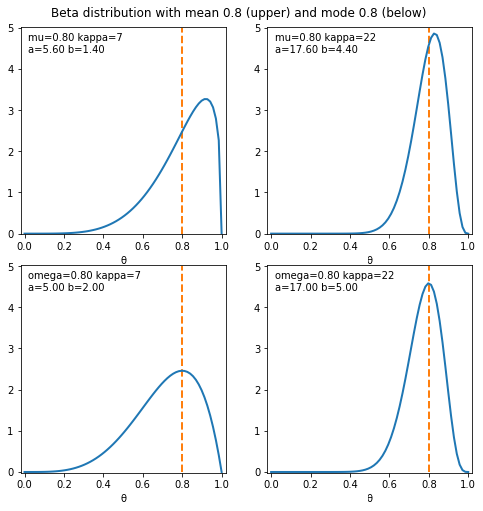

In [3]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.suptitle('Beta distribution with mean 0.8 (upper) and mode 0.8 (below)')
fig.tight_layout()
fig.subplots_adjust(top=0.94)

param_kappa = [7, 22]
domain = np.linspace(0.0, 1.0, 70)
mu = 0.8
omega = 0.8

def a_from_mu (mu, kappa): return mu*kappa
def b_from_mu (mu, kappa): return (1-mu)*kappa
def a_from_omega (omega, kappa): return omega*(kappa-2)+1
def b_from_omega (omega, kappa): return (1-omega)*(kappa-2)+1

def plot_beta (ax, a, b, mu, kappa, label):
    with pm.Model():
        beta = pm.Beta(
            name=f"theta", 
            alpha=a,
            beta=b,
            transform=None
        )
        image = [ math.exp( beta.logp( {"theta": theta} ) ) 
                    for theta in domain
        ]
        ax.vlines([mu], ymin=0, ymax=5.0, color='C1', ls='--', linewidth=2)
        ax.plot(domain, image, linewidth=2)
        ax.text(0.02, 4.7, f"{label}={mu:0.2f} kappa={kappa:0d}")
        ax.text(0.02, 4.4, f"a={a:0.2f} b={b:0.2f}")
        ax.axis([-0.02, 1.02, -0.02, 5.02])
        ax.axis([-0.02, 1.02, -0.02, 5.02])
        ax.set_xlabel('θ')       
        
for i in range(0, 2):
    a = a_from_mu (mu, param_kappa[i])
    b = b_from_mu (mu, param_kappa[i])
    plot_beta(ax[0,i], a, b, mu, param_kappa[i], "mu")
    
for i in range(0, 2):
    a = a_from_omega (omega, param_kappa[i])
    b = b_from_omega (omega, param_kappa[i])
    plot_beta(ax[1,i], a, b, omega, param_kappa[i], "omega")
    
plt.show()

* In the left column, $\kappa$ is smaller, thus the distribution is wider.
* In the right column, the concentration $\kappa$ is larger, thus the distribution is more narrow.
* In the top row, we show densities with mean $\mu=0.8$ it is a bit hard to guess the shape.
* In the bottom row, we show densities with mode $\omega=0.8$. Here we know that the peak of the density is at the mode point.

### Prior knowledge about mean and standard deviation

* PyMC3 allows to parameterize the distribution using a,b ($\alpha$, $\beta$) as we did above, and using mean and standard deviation ($\sigma$).  No worries though. [The documentation](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta) shows how to compute variance (the square of standard deviation) from values of a, b, and how to get $\kappa$ form variance and mean. These are also listed in equation (6.7) in the book.
* Beware than when using standard deviation the value should be less 0.28867 (this is a standard deviation of a uniform distribution on [0,1] which is the most uninformed distribution on $\theta$).

## Posterior Analysis with a Beta Prior (Section 6.3)

* We have a prior candidate, and a likelihood, we can compute the posterior density using Bayes rule:

\begin{align}
    p(\theta \mid z, N) & = \frac{p (z, N \mid \theta) p(\theta)}{p(z,N)} \\[5mm]
                        & = \theta^z (1-\theta)^{N-z} \frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)p(z,N)}\\[5mm]
                        & = \frac{\theta^{(z+a)-1} (1-\theta)^{(N-z+b)-1}}{B(a,b)p(z,N)}\\[5mm]
                        & = \frac{\theta^{(z+a)-1} (1-\theta)^{(N-z+b)-1}}{B(z+a,N-z+b)}\\[5mm]
                        & = \textrm{beta}(z+a,N-z+b)
\end{align}

* The last step above is non-obvious; We have looked at the numerator, and noticed that it looks like a numerator of a beta density function with $\alpha=z+a$ and $\beta=N-z+b$.
* By definition beta function $\textrm{B}(z+a,N-z+b)$ is thus a normalizing denominator for this numerator. (Check the section about the beta density function above.)
* As we wanted we obtained a posterior in the same form as the prior (a beta density function)
* **Computing a posterior for $N$ Bernoulli experiments with a beta prior amounts to computing a new beta density with updated parameters**

## Posterior as a compromise of prior and likelihood
* We were discussing this last week, using grid approximation graphs
* We try to appreciate this analytically this week.
* Recall that beta distributions have mean determined using parameters.
* It turns out that the posterior mean can be expressed as a weighted average of the likelihood average and prior mean:

<img src="posterior-mean.png">

* The left-hand side above is the mean of the posterior (Why?)
* The second component "data" is the proportion of heads in the data
* The third component "prior" is the beta distribution mean for the prior
* The likelihood is weighed by the fraction of experimetns in the total amount of knowledge (number of trials we have seen, or believe we have seen)
* The prior is weighed by the fraction of prior belief in the total amount of experience (number of trials we have seen, or believe we have seen)
* In both weights the denominator is the total number of trials and knowledge we have
* So the extent of the shift of the mean will depend on the proportion between the prior parameters a,b and the number of experiments in the data.

<img src="prior-compromise.png" width="500">
Copyright © Kruschke, J. K. (2014). Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan. 2nd
Edition. Academic Press / Elsevier.

## Priors that are not a beta distribution

* If we cannot express the prior as a beta distribution, another posterior calculation method is needed.
    * For example if our prior is not unimodal. For instance we know results come from two wildly different populations but we do not know from which one.
* We can use *grid approximation* like last week.
    * This relied on selecting discrete values of $\theta$ and prior values for them  (for a finite number we can always choose constants we believe in for any shape)
    * The likelihood equation is the same both week and this week.
    * We can obtain a grid approximating the posterior by sampling the Bayes rule for different values of theta

# Homework Exercises

1. Study Section 6.4.2 and reproduce Fig. 6.5 in Python.  Follow the same method we used in week 2 using 1000 intervals for $\theta$
2. Exercise 6.1 (make sure that you plot the intermediate posteriors, and compare the plots; you can reuse the plotting code from above, or make your own; or use any other way of plotting the beta density function given parameters, an online service, etc.)
3. Exercise 6.2 (you can plot HDP instead of HDI using pymc3.stats.hpd, or using posterior plots with credible_interval argument as we used in the last two weeks)
4. Exercise 6.3
5. Exercise 6.4 + 6.5